# Deep Reinforcement Learning on the Stock Market (BASIC TASK)

### Implementing a Deep Reinforcement Learning (DRL) agent to trade using stock market data involves several steps, including setting up the environment, defining the reward function, and training the agent using a DRL algorithm. In this example, we'll use the Proximal Policy Optimization (PPO) algorithm, which is a popular DRL algorithm for continuous action spaces. We will fetch stock market data from Yahoo Finance using the yfinance library.

# Basic Tasks
Fetch Stock Market Data: We'll use the yfinance library to download historical stock price data.
Define the Environment: Create a trading environment where the agent can interact with the market by buying, selling, or holding a stock.
Define the Reward Function: The reward function will be based on the profit and loss from trades.



In [1]:
!pip install yfinance stable-baselines3 gym


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Then, fetch the stock market data:

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fetch stock market data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-01-01"

data = fetch_stock_data(ticker, start_date, end_date)
print(data.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960464  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251129  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826851  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650375  132079200


# Define the Trading Environment
We will define a custom environment using OpenAI's Gym framework:

In [27]:
import gym
from gym import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.current_step = 0

        # Define action and observation space
        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: [price, moving average, moving average convergence divergence, relative strength index]
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

        # Initial investment amount
        self.initial_balance = 10000
        self.cash_in_hand = self.initial_balance
        self.stock_owned = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.initial_price = self.df.loc[self.current_step, 'Close']

    def _next_observation(self):
        obs = np.array([
            self.df.loc[self.current_step, 'Close'],
            self.df.loc[self.current_step, 'Moving_Average'],
            self.df.loc[self.current_step, 'MACD'],
            self.df.loc[self.current_step, 'RSI']
        ])
        return obs

    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, 'Close']

        if action == 0:  # Buy
            shares_bought = self.cash_in_hand // current_price
            self.cash_in_hand -= shares_bought * current_price
            self.stock_owned += shares_bought

        elif action == 1:  # Hold
            pass

        elif action == 2:  # Sell
            self.cash_in_hand += self.stock_owned * current_price
            self.stock_owned = 0

        self.net_worth = self.cash_in_hand + self.stock_owned * current_price
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def step(self, action):
        self._take_action(action)

        self.current_step += 1

        if self.current_step >= len(self.df) - 1:
            self.current_step = 0  # Reset for the next episode

        obs = self._next_observation()
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0

        return obs, reward, done, {}

    def reset(self):
        self.cash_in_hand = self.initial_balance
        self.stock_owned = 0
        self.net_worth = self.initial_balance
        self.current_step = 0
        self.initial_price = self.df.loc[self.current_step, 'Close']

        return self._next_observation()

    def render(self, mode='human', close=False):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.cash_in_hand}')
        print(f'Shares held: {self.stock_owned}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')


In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Fetch stock market data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

ticker = "AAPL"  # Example: Apple Inc.
start_date = "2020-01-01"
end_date = "2023-01-01"

data = fetch_stock_data(ticker, start_date, end_date)

# Add technical indicators to the stock data
def add_indicators(df):
    df['Moving_Average'] = df['Close'].rolling(window=14).mean()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df = df.dropna()
    return df

data = add_indicators(data)

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.current_step = 0

        # Define action and observation space
        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: [price, moving average, MACD, RSI]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)

        # Initial investment amount
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance

    def _next_observation(self):
        obs = np.array([
            self.df.iloc[self.current_step]['Close'],
            self.df.iloc[self.current_step]['Moving_Average'],
            self.df.iloc[self.current_step]['MACD'],
            self.df.iloc[self.current_step]['RSI']
        ])
        return obs

    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]['Close']

        if action == 0:  # Buy
            shares_bought = self.balance // current_price
            self.balance -= shares_bought * current_price
            self.shares_held += shares_bought

        elif action == 1:  # Hold
            pass

        elif action == 2:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0

        self.net_worth = self.balance + self.shares_held * current_price
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def step(self, action):
        self._take_action(action)

        self.current_step += 1

        if self.current_step >= len(self.df) - 1:
            self.current_step = 0  # Reset for the next episode

        obs = self._next_observation()
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0

        return obs, reward, done, {}

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.current_step = 0

        return self._next_observation()

    def render(self, mode='human', close=False):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

# Create the trading environment
env = StockTradingEnv(data)

# Vectorize the environment
env = make_vec_env(lambda: env, n_envs=1)

# Create and train the PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save the trained model
model.save("ppo_stock_trading")

# Load the trained model
model = PPO.load("ppo_stock_trading")




[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 744  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 549           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.2517557e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.61e+10      |
|    n_updates            | 10            |
|    policy_gradient_loss | -8.46e-06     |
|    value_loss           | 1.71e+11      |
-------------------------

# Testing and Plotting
 We will test the trained model and plot the results:

1. Net Worth Over Time: This plot shows how the agent's net worth changes with each step.
2. Actions Over Time: This plot indicates the actions taken by the agent at each step, helping to understand the decision-making pattern.
3. Rewards Over Time: This plot shows the rewards received at each step, which helps in evaluating the immediate impact of the agent's actions.
4. Portfolio Value Over Time: This plot presents the combined value of cash and stocks, giving a full picture of the agent's portfolio performance.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


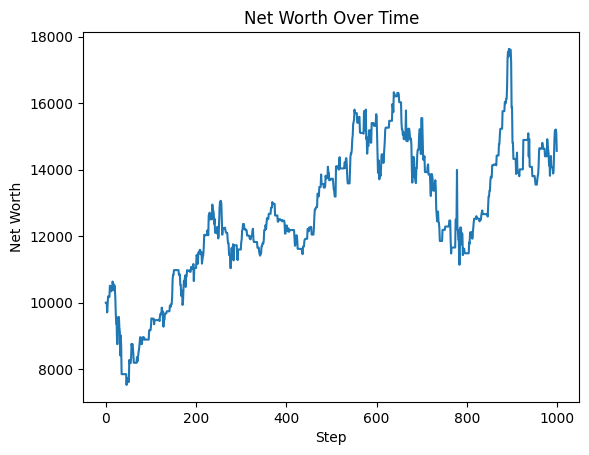

In [32]:
# Test the trained model
obs = env.reset()
done = False
net_worths = []

# Set a maximum number of steps to prevent infinite loops
max_steps = 1000
steps = 0

while not done and steps < max_steps:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    net_worths.append(env.get_attr('net_worth')[0])
    env.render()
    steps += 1

# Plot net worth over time
plt.plot(net_worths)
plt.xlabel('Step')
plt.ylabel('Net Worth')
plt.title('Net Worth Over Time')
plt.show()